In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import pickle
import requests
import time
from datasets import load_dataset

d:\programs\anaconda3\envs\ait\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.utils import draw_bounding_boxes

In [3]:
ds = load_dataset("keremberke/license-plate-object-detection", name="full")


Found cached dataset license-plate-object-detection (C:/Users/pczum/.cache/huggingface/datasets/keremberke___license-plate-object-detection/full/1.0.0/e7740c5ed939eb2184b6f17aee84b3a304e2f46f093835a839bcf19f0ca38ce4)
100%|██████████| 3/3 [00:00<00:00, 750.23it/s]


In [100]:
x_train = ds['train']['image']


In [101]:
y_train = [x['bbox'] for x in ds['train']['objects']]

In [102]:
ignore_list = []
for i in range(len(y_train)):
    if len(y_train[i]) != 1:
        ignore_list.append(i)

166


In [103]:
#remove ignore list from y_train
y_train = [y_train[i] for i in range(len(y_train)) if i not in ignore_list]
#remove ignore list from x_train
x_train = [x_train[i] for i in range(len(x_train)) if i not in ignore_list]

In [107]:
ymin = []
xmin = []
ymax = []
xmax = []
for i in range(len(y_train)):
    ymin.append(y_train[i][0][0])
    xmin.append(y_train[i][0][1])
    ymax.append(y_train[i][0][2])
    xmax.append(y_train[i][0][3])

In [126]:
#create dataframe for training
df = pd.DataFrame()
df['image'] = x_train
df['ymin'] = ymin
df['xmin'] = xmin
df['ymax'] = ymax
df['xmax'] = xmax

#set type to float32
df['ymin'] = df['ymin'].astype(np.float32)
df['xmin'] = df['xmin'].astype(np.float32)
df['ymax'] = df['ymax'].astype(np.float32)
df['xmax'] = df['xmax'].astype(np.float32)


In [127]:
#show df columns
df.columns

Index(['image', 'ymin', 'xmin', 'ymax', 'xmax'], dtype='object')

In [128]:
#df head without image
df.drop(columns=['image']).head()

,ymin,xmin,ymax,xmax
0,184.0,592.0,131.839996,63.360001
1,786.0,387.0,76.800003,51.840000
2,867.0,262.0,63.333378,27.346638
3,398.0,689.0,108.160004,24.340036
4,262.0,590.0,58.880001,14.089716


In [145]:
def show_img(index):
    img = df['image'][index]
    width = example['width']
    height = example['height']
    img = np.array(img)
    #to tensor
    img = tf.convert_to_tensor(img)
    #expand dims
    img = tf.expand_dims(img, axis=0)
    #convert to float
    img = tf.cast(img, dtype=tf.float32)
    #normalize
    img = img/255.0
    box = [df['ymin'][index], df['xmin'][index], df['ymax'][index], df['xmax'][index]]
    #convert to relative coordinates for plotting 
    boxes_scaled = [[box[1]/height, box[0]/width, box[1]/height + box[3]/height, box[0]/width + box[2]/width,]]
    boxes_scaled = tf.expand_dims(boxes_scaled, axis=0)
    boxes_scaled = tf.cast(boxes_scaled, dtype=tf.float32)

    i = tf.image.draw_bounding_boxes(img, boxes_scaled, [[1.0, 0.0, 0.0]]*len(boxes_scaled))
    plt.imshow(i[0])

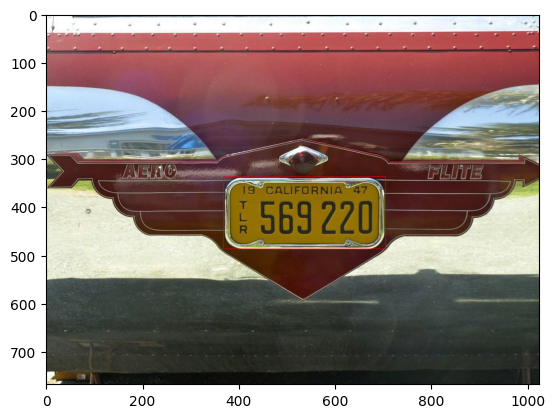

In [148]:
show_img(10)

## Define the model

In [114]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3
